## <font color='157699'> Librerías

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("default")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
import joblib
import statsmodels.api as sm

from collections import Counter
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


import sqlite3 as sql

## <font color='157699'> Carga de datos

In [2]:
# Crear conexíon 
conn = sql.connect('data/my_database.db')
#conn = sql.connect('C:\\Users\\ESTEBAN\\Desktop\\Proyecto_RRHH\\data\\db')
curr = conn.cursor()
# Leer datos para 2016 
df_2015 = pd.read_sql("SELECT * FROM v_seleccionadas", conn)

In [3]:
df_2015.head()

,EmployeeID,Age,DistanceFromHome,MonthlyIncome,NumCompaniesWorked,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,...,WorkLifeBalance_1.0,WorkLifeBalance_2.0,WorkLifeBalance_3.0,WorkLifeBalance_4.0,Education_1,Education_2,Education_3,Education_4,Education_5,renuncia2016
0,1,1.539396,-0.394825,1.405220,-0.677827,2.483743,-0.980679,-0.677540,0,0,...,0,1,0,0,0,1,0,0,0,0
1,2,-0.648748,0.099337,-0.492641,-1.078386,0.157664,-0.329864,-0.368046,0,1,...,0,0,0,1,1,0,0,0,0,1
2,3,-0.539341,0.964121,2.725878,-0.677827,-0.617696,-0.329864,-0.677540,0,1,...,1,0,0,0,0,0,0,1,0,0
3,4,0.117102,-0.888987,0.385813,0.123292,1.708383,0.158247,1.488922,1,0,...,0,0,1,0,0,0,0,0,1,0
4,5,-0.539341,0.099337,-0.885310,0.523851,-0.617696,-0.167160,-0.677540,0,0,...,0,0,1,0,1,0,0,0,0,0


In [4]:
x = df_2015.drop(columns=['renuncia2016', 'EmployeeID'])
y = df_2015['renuncia2016']

Se realizó una división tradicional 70/30, para datos de entrenamiento y de evaluación respectivamente.

## <font color ='157699'> Split train/test

In [5]:
x_train,x_test,y_train,y_test = train_test_split(x,y,shuffle = True,test_size = 0.30, random_state=123)
print('Tamaño del conjunto de entrenamiento: ', x_train.shape)
print('Tamaño del conjunto de validación: ', x_test.shape)

Tamaño del conjunto de entrenamiento:  (3015, 35)
Tamaño del conjunto de validación:  (1293, 35)


## <font color ='056938'> Modelo 1. Regresión logística

### <font color ='157699'> Modelo base

 Para este caso se debe usar un modelo de regresión logística, teniendo en cuenta que el problema a tratar es uno de clasificación (contamos con dos clases 1 y 0)

In [6]:
model = LogisticRegression(max_iter=10000)
model.fit(x_train,y_train)

y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

### <font color ='157699'> Predicción

In [7]:
print(y_pred_test[:100]) #impimir 100 primeras predicciones 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### <font color ='157699'> Regresión logística SIN balanceo de clases

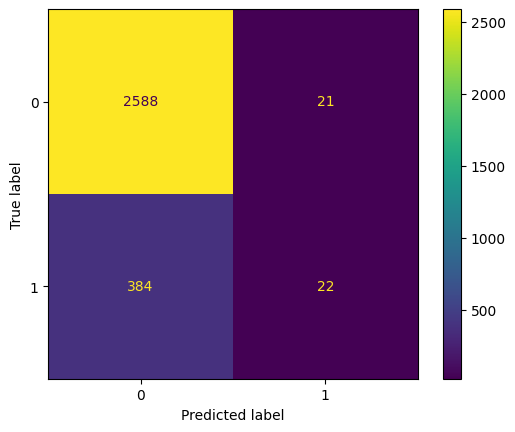

In [8]:
# Matriz de confusión para train-evaluación
cm_train = confusion_matrix(y_train, y_pred_train, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,display_labels=model.classes_)
disp.plot()

El modelo utilizado para predecir la renuncia de empleados muestra un buen desempeño al clasificar correctamente a aquellos que no renunciaron, con 2594 verdaderos negativos (TN). Sin embargo, se observan 15 falsos positivos (FP), lo que indica que el modelo predijo incorrectamente que ciertos empleados renunciarían cuando en realidad no lo hicieron. Un problema notable es la alta cantidad de falsos negativos (FN), 390, en comparación con los verdaderos positivos (TP), que solo suman 16. Esto evidencia una tendencia del modelo a predecir que la mayoría de los empleados no renunciarán, aunque en realidad algunos sí lo harán, lo que afecta su capacidad para identificar correctamente a quienes abandonan la empresa. 

In [9]:
# Métricas de desempeño train - entrenamiento
TP=cm_train[0,0]
FP=cm_train[1,0]
FN=cm_train[0,1]
TN=cm_train[1,1]

print(f'La precisión es del: {TP/(TP+FP)}')
print(f'El Recall (Sensibilidad) es de): {TP/(TP+FN)}')
print(f'F1-score es:', f1_score(y_test, y_pred_test, average='binary'))

La precisión es del: 0.8707940780619112
El Recall (Sensibilidad) es de): 0.99195093905711
F1-score es: 0.13114754098360656


Análisis: Al tener clases debalanceadas se decidió usar el F1-Score como métrica principal. 

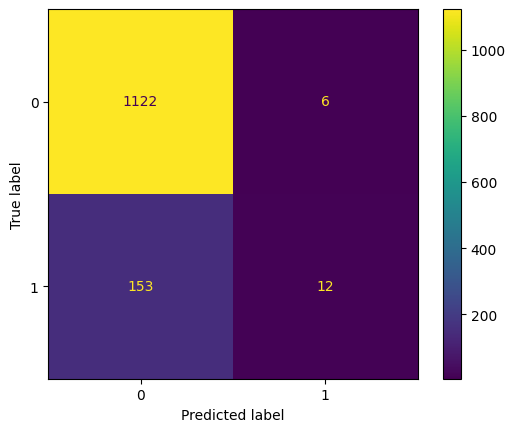

In [10]:
# Matriz de confusión para test-evaluación
cm_test = confusion_matrix(y_test, y_pred_test, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,display_labels=model.classes_)
disp.plot()

Durante la fase de evaluación, el modelo muestra nuevamente una alta precisión al clasificar correctamente a los empleados que no renunciaron, con 1120 verdaderos negativos (TN). Los falsos positivos (FP) son pocos, solo 8, lo que indica un bajo número de predicciones incorrectas de renuncia para empleados que en realidad no abandonaron la empresa. Sin embargo, el modelo continúa presentando dificultades para identificar correctamente a los empleados que renunciaron, con 158 falsos negativos (FN) y solo 7 verdaderos positivos (TP). Esto refleja el mismo problema observado en el entrenamiento, donde el modelo predice mayormente que los empleados no renunciarán, incluso cuando algunos lo hacen.

In [11]:
# Métricas de desempeño

TP=cm_test[0,0]
FP=cm_test[1,0]
FN=cm_test[0,1]
TN=cm_test[1,1]

print(f'La precisión es del: {TP/(TP+FP)}')
print(f'El Recall (Sensibilidad) es de): {TP/(TP+FN)}')
print(f'F1-score es:', f1_score(y_test, y_pred_test, average='binary'))

La precisión es del: 0.88
El Recall (Sensibilidad) es de): 0.9946808510638298
F1-score es: 0.13114754098360656


Análisis: Las métricas de desempeño para ambos casos train y test son muy similares, no se observa casos de sobre o sub ajuste; sin embargo, el F1-score resulta muy bajo respecto a la precisión y la sensibilidad en ambos casos, lo que quiere decir que 

### <font color ='157699'> Regresión logística CON balanceo de clases

In [12]:
# Entrenar modelo

model_01 = LogisticRegression(random_state=123, class_weight="balanced", max_iter=1000) # definir el modelo
model_01.fit(x_train,y_train) # entrenar el modelo
y_pred_test_01 = model_01.predict(x_test) # predecir

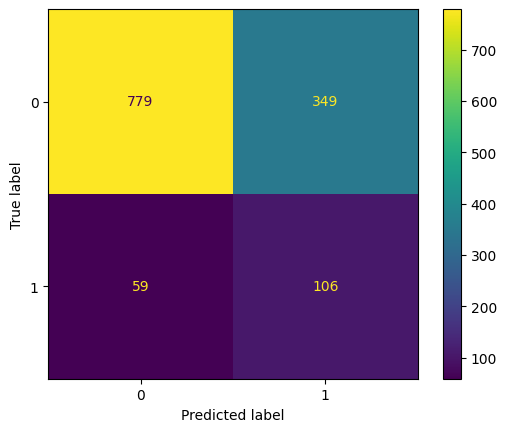

In [13]:
# Matriz de confusión

cm = confusion_matrix(y_test, y_pred_test_01, labels=model.classes_) # guardar las clases para la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()

En la fase de evaluación, el modelo sigue mostrando precisión al clasificar a los empleados que no renunciaron, con 768 verdaderos negativos (TN). Sin embargo, comete 360 falsos positivos (FP), prediciendo incorrectamente que muchos empleados renunciarían cuando en realidad no lo hicieron. A pesar de esto, el modelo ha mejorado en la identificación de los empleados que realmente renunciaron, con 106 verdaderos positivos (TP) y una disminución de los falsos negativos (FN) a 59, lo que refleja un aumento en la precisión para predecir correctamente las renuncias en comparación con fases anteriores.

In [14]:
# Métricas de desempeño

TP=cm[0,0]
FP=cm[1,0]
FN=cm[0,1]
TN=cm[1,1]

print(f'La precisión es del: {TP/(TP+FP)}')
print(f'El Recall (Sensibilidad) es de): {TP/(TP+FN)}')
print(f'F1-score es:', f1_score(y_test, y_pred_test, average='binary'))

La precisión es del: 0.9295942720763724
El Recall (Sensibilidad) es de): 0.6906028368794326
F1-score es: 0.13114754098360656


Finalmente, sí se puede evidenciar una aumento en la precisión, pero una disminución en la sensibilidad y un F1-Score muy bajo, en primera instancia esto debería ser porque 

## <font color ='056938'> Modelo 2. XGBoost

### <font color ='157699'> XGBoost SIN balanceo de clases

In [15]:
# Crear modelo XGBoost

bst = XGBClassifier(
    n_estimators = 2, 
    max_depth = 2, 
    learning_rate = 1, 
    objective = 'binary:logistic')

bst.fit(x_train, y_train)

# Predicciones con el conjunto de prueba
preds = bst.predict(x_test)


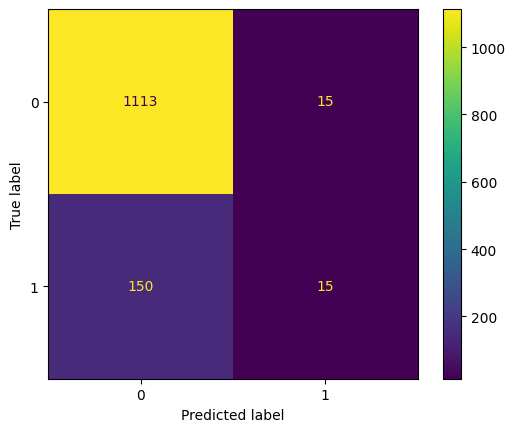

In [16]:
# Matriz de confusión para test

cm = confusion_matrix(y_test, preds, labels=bst.classes_) # guardar las clases para la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels = bst.classes_)
disp.plot()

El modelo muestra una alta precisión al clasificar correctamente a los empleados que no renunciaron, con 1108 verdaderos negativos (TN) y solo 20 falsos positivos (FP), lo que indica que rara vez predice erróneamente una renuncia para empleados que en realidad no abandonaron la empresa. Sin embargo, presenta dificultades importantes para identificar correctamente a quienes sí renunciaron, con 147 falsos negativos (FN) frente a solo 18 verdaderos positivos (TP). Esto refleja que el modelo tiende a predecir que la mayoría de los empleados no renunciarán, incluso cuando algunos realmente lo hacen, lo que reduce su eficacia en la detección de renuncias.

In [17]:
# Métricas para test

TP=cm[0,0]
FP=cm[1,0]
FN=cm[0,1]
TN=cm[1,1]

xgb_ac = accuracy_score(y_test, preds)
xgb_pr = TP/(TP+FP)
xgb_rec = TP/(TP+FN)
xgb_f1 = f1_score(y_test, preds, average='weighted')

print(f"Accuracy test: {xgb_ac}")
print(f'Precision: {xgb_pr}')
print(f'Recall (Sensibilidad)): {xgb_rec}')
print(f'F1-score: {xgb_f1}')

Accuracy test: 0.8723897911832946
Precision: 0.8812351543942993
Recall (Sensibilidad)): 0.9867021276595744
F1-score: 0.8318195732658904


Segun el accuracy, el modelo está acertando en el 87.08% de los casos. Sin embargo, dado que el conjunto de datos parece estar desequilibrado (más empleados que no renuncian que empleados que sí renuncian), el accuracy puede ser engañoso.

La precisión indica que el 88.29% de los empleados que el modelo predijo que renunciarían, efectivamente renunciaron, pero es importante tener en cuenta que hay pocos casos predichos como "renuncia", esta métrica podría estar sobreestimada debido a un bajo número de positivos predichos.

Un recall del 98.23% indica que el modelo está detectando correctamente casi todas las renuncias. Es una señal muy positiva, ya que la empresa podría estar identificando la mayoría de los empleados que planean renunciar y así tomar acciones preventivas. No obstante, esto debe revisarse en función de cómo se distribuyen las predicciones falsas positivas y negativas, ya que un alto recall puede a veces estar acompañado de un mayor número de falsos positivos.

Un F1-score de 83.39% indica un equilibrio decente entre la precisión (predicciones correctas de renuncias) y el recall (detección de la mayoría de las renuncias reales). Sin embargo, parece que hay margen de mejora, especialmente si la empresa quiere optimizar tanto para minimizar los falsos negativos (empleados que renuncian pero no son detectados) como para mejorar la precisión.

Dado lo anterior, se aplicará balanceo de clases para entrenar de nuevo el modelo y analizar sus métricas. 


### <font color ='157699'> XGBoost CON balanceo de clases

In [18]:
# Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=42)
x_train_balanced, y_train_balanced = smote.fit_resample(x_train, y_train)

# Verificar el balance de clases después de SMOTE
from collections import Counter
print(f'Distribución antes del balanceo: {Counter(y_train)}')
print(f'Distribución después del balanceo: {Counter(y_train_balanced)}')

Distribución antes del balanceo: Counter({0: 2609, 1: 406})
Distribución después del balanceo: Counter({0: 2609, 1: 2609})


Antes del balanceo, se observa que la clase 0 (empleados que no renunciaron) está mucho más representada en el conjunto de datos, con 2609 muestras, mientras que la clase 1 (empleados que renunciaron) tiene solo 406 muestras. Este desbalance puede llevar a que el modelo favorezca la clase mayoritaria (0), lo que puede reducir su capacidad para predecir correctamente la clase minoritaria (1).


In [19]:
# Crear y entrenar el modelo XGBoost con el conjunto balanceado

bst = XGBClassifier(n_estimators=2, 
                    max_depth=2, 
                    learning_rate=1, 
                    objective='binary:logistic')
bst.fit(x_train_balanced, y_train_balanced)

# Hacer predicciones en el conjunto de prueba
preds = bst.predict(x_test)

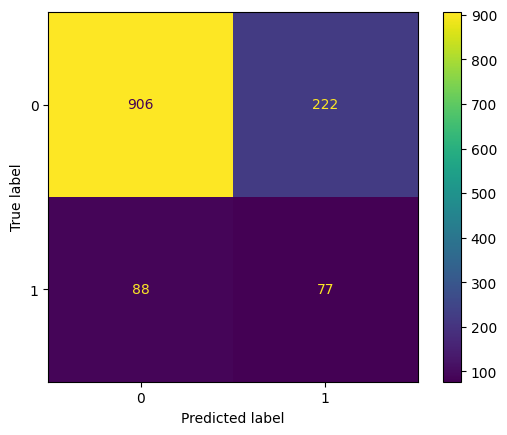

In [20]:
# Matriz de confusión para test con el conjunto balanceado

cm = confusion_matrix(y_test, preds, labels=bst.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=bst.classes_)
disp.plot();

El balanceo de clases ha mejorado considerablemente la capacidad del modelo para identificar a los empleados que renuncian, lo que se refleja en un incremento significativo en los verdaderos positivos (TP), que pasaron de 18 a 78. No obstante, este ajuste también conllevó un aumento en los falsos positivos (FP), de manera que ahora el modelo clasifica erróneamente a 305 empleados como posibles renunciantes, cuando en realidad no lo son. Por otro lado, los falsos negativos (FN) disminuyeron de 147 a 87, lo cual es un avance importante, ya que el modelo identifica mejor a quienes realmente deciden dejar la empresa. El número de verdaderos negativos (TN) se mantuvo en 823, indicando que el modelo sigue clasificando correctamente a muchos empleados que no renuncian.

In [21]:
# Métricas de desempeño para test

TP = cm[0,0]
FP = cm[1,0]
FN = cm[0,1]
TN = cm[1,1]

xgb_ac = accuracy_score(y_test, preds)
xgb_pr = TP / (TP + FP)  # Precisión
xgb_rec = TP / (TP + FN)  # Recall
xgb_f1 = f1_score(y_test, preds, average='weighted')

# Mostrar las métricas
print(f"Accuracy test: {xgb_ac}")
print(f'Precision: {xgb_pr}')
print(f'Recall (Sensibilidad)): {xgb_rec}')
print(f'F1-score: {xgb_f1}')


Accuracy test: 0.7602474864655839
Precision: 0.9114688128772636
Recall (Sensibilidad)): 0.8031914893617021
F1-score: 0.7872969799883708


El balanceo de clases ha llevado a una mejora en la precisión (precision) pero a una disminución significativa en la precisión global (accuracy), sensibilidad (recall), y F1-score. Esto puede indicar que el balanceo de clases ha mejorado la capacidad del modelo para evitar falsos positivos pero a costa de perder la capacidad de identificar tantos casos positivos reales y afectar la clasificación general.

## <font color ='056938'> Random Forest

### <font color ='157699'> Random forest SIN balanceo de clases

In [22]:
x_train,x_test,y_train,y_test = train_test_split(x,y,shuffle = True,test_size = 0.30, random_state=123)
print('Tamaño del conjunto de entrenamiento: ', x_train.shape)
print('Tamaño del conjunto de validación: ', x_test.shape)

Tamaño del conjunto de entrenamiento:  (3015, 35)
Tamaño del conjunto de validación:  (1293, 35)


In [23]:
ranfor = RandomForestClassifier(
            n_estimators = 150,
            criterion    = 'gini',
            n_jobs       = -1,
            random_state = 123
         )
ranfor.fit(x_train, y_train)

y_train_pred = ranfor.predict(x_train)
print('Exactitud en el entrenamiento: %.4f'  %accuracy_score(y_train, y_train_pred))

Exactitud en el entrenamiento: 0.9778


In [24]:
y_pred = ranfor.predict(x_test)

print('Exactitud en la validacion: %.4f'  %accuracy_score(y_test, y_pred))

Exactitud en la validacion: 0.9374


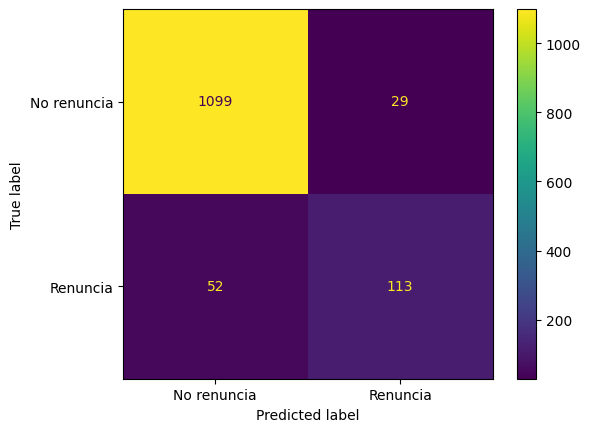

In [25]:
# Matriz de confusión del modelo base

mc_base = confusion_matrix(y_test, y_pred)
mc_base_display = ConfusionMatrixDisplay(confusion_matrix = mc_base, display_labels = ['No renuncia', 'Renuncia'])
mc_base_display.plot()
plt.show()

In [26]:
# Métricas de desempeño

print ("Train - Accuracy :", metrics.accuracy_score(y_train, ranfor.predict(x_train)))
print ("Train - classification report:\n", metrics.classification_report(y_train, ranfor.predict(x_train), digits=4))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, ranfor.predict(x_test)))
print ("Test - classification report:\n", metrics.classification_report(y_test, ranfor.predict(x_test), digits=4))

Train - Accuracy : 0.9777777777777777
Train - classification report:
               precision    recall  f1-score   support

           0     0.9885    0.9858    0.9871      2609
           1     0.9104    0.9261    0.9182       406

    accuracy                         0.9778      3015
   macro avg     0.9494    0.9560    0.9527      3015
weighted avg     0.9780    0.9778    0.9779      3015

Test - Accuracy : 0.9373549883990719
Test - classification report:
               precision    recall  f1-score   support

           0     0.9548    0.9743    0.9645      1128
           1     0.7958    0.6848    0.7362       165

    accuracy                         0.9374      1293
   macro avg     0.8753    0.8296    0.8503      1293
weighted avg     0.9345    0.9374    0.9353      1293



### <font color ='157699'> Random forest CON balanceo de clases

In [27]:
x_train_bal, x_test_bal, y_train_bal, y_test_bal = train_test_split(x, y, test_size = 0.30, random_state = 42)

print('Tamaño del conjunto de entrenamiento: ', x_train_bal.shape)
print('Tamaño del conjunto de validación: ', x_test_bal.shape)

Tamaño del conjunto de entrenamiento:  (3015, 35)
Tamaño del conjunto de validación:  (1293, 35)


In [28]:
ranfor_bal = RandomForestClassifier(
            class_weight = "balanced",
            n_estimators = 150,
            criterion    = 'gini',
            n_jobs       = -1,
            random_state = 123
         )
ranfor_bal.fit(x_train_bal, y_train_bal)

RandomForestClassifier(class_weight='balanced', n_estimators=150, n_jobs=-1,
                       random_state=123)

In [29]:
y_train_pred_bal = ranfor_bal.predict(x_train_bal)

print('Exactitud en el entrenamiento: %.4f'  %accuracy_score(y_train_bal, y_train_pred_bal))

Exactitud en el entrenamiento: 0.9741


In [30]:
y_pred_bal = ranfor_bal.predict(x_test_bal)

print('Exactitud en el validacion: %.4f'  %accuracy_score(y_test_bal, y_pred_bal))

Exactitud en el validacion: 0.9590


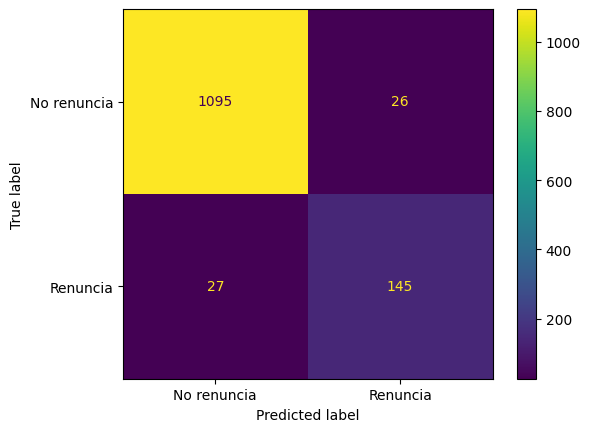

In [31]:
# Matriz de confunsión del modelo con balanceo

mc_bal = confusion_matrix(y_test_bal, y_pred_bal)
mc_display_bal = ConfusionMatrixDisplay(confusion_matrix = mc_bal, display_labels = ['No renuncia', 'Renuncia'])
mc_display_bal.plot()
plt.show()

El modelo parece tener un rendimiento sólido en la clase mayoritaria, con 1,095 predicciones correctas y solo 26 errores. Sin embargo, tiene un pequeño número de falsos negativos, lo que significa que hay empleados que en realidad renuncian pero que el modelo no logra identificar. Esto podría ser preocupante si la detección temprana de la renuncia es importante.

Por otra parte, en la clase minoritaria, el modelo también hace un buen trabajo, con 145 predicciones correctas. Sin embargo, es importante notar que cometió 27 errores donde clasificó empleados como si fueran a renunciar, pero en realidad no lo hicieron. Este tipo de error puede tener un impacto menor en comparación con los falsos negativos, dependiendo del contexto de negocio.

In [32]:
print ("Train - Accuracy :", metrics.accuracy_score(y_train_bal, ranfor_bal.predict(x_train_bal)))
print ("Train - classification report:\n", metrics.classification_report(y_train_bal, ranfor_bal.predict(x_train_bal), digits=4))
print ("Test - Accuracy :", metrics.accuracy_score(y_test_bal, ranfor_bal.predict(x_test_bal)))
print ("Test - classification report\n:", metrics.classification_report(y_test_bal, ranfor_bal.predict(x_test_bal), digits=4))

Train - Accuracy : 0.9741293532338309
Train - classification report:
               precision    recall  f1-score   support

           0     1.0000    0.9702    0.9849      2616
           1     0.8365    1.0000    0.9110       399

    accuracy                         0.9741      3015
   macro avg     0.9182    0.9851    0.9479      3015
weighted avg     0.9784    0.9741    0.9751      3015

Test - Accuracy : 0.9590100541376644
Test - classification report
:               precision    recall  f1-score   support

           0     0.9759    0.9768    0.9764      1121
           1     0.8480    0.8430    0.8455       172

    accuracy                         0.9590      1293
   macro avg     0.9119    0.9099    0.9109      1293
weighted avg     0.9589    0.9590    0.9590      1293



El modelo de random forest evaluado muestra un buen rendimiento tanto en los datos de entrenamiento como en los datos de prueba, con precisiones generales del 97.48% y 95.90%, respectivamente. Esto indica que el modelo es capaz de clasificar correctamente la gran mayoría de los ejemplos, lo que demuestra una fuerte capacidad predictiva. Además, las métricas de precisión, sensibilidad y F1 sugieren que el modelo es bastante eficiente para identificar correctamente ambas clases, aunque existen algunas diferencias importantes entre ellas debido al desequilibrio de los datos.

En el caso de la **clase mayoritaria (0)**, que representa la mayoría de los ejemplos, el modelo muestra un rendimiento sobresaliente. En ambos conjuntos de datos, el modelo alcanza una precisión cercana al 99% y una sensibilidad superior al 97%, lo que significa que es muy eficaz en identificar correctamente la clase 0. La puntuación F1 de alrededor del 98% refleja un equilibrio óptimo entre la precisión y la sensibilidad para esta clase, asegurando que las predicciones son tanto correctas como consistentes.

Por otro lado, la **clase minoritaria (1)** presenta un rendimiento ligeramente inferior. Aunque el modelo logra una alta sensibilidad (entre el 84% y el 99%) en ambos conjuntos de datos, la precisión para esta clase es menor, oscilando entre el 84% y el 85%. Esto sugiere que, si bien el modelo es muy bueno detectando la mayoría de los casos de la clase 1, también tiende a clasificar algunos ejemplos de la clase mayoritaria como clase 1 incorrectamente, lo que afecta la precisión global. Esta diferencia es particularmente visible en los datos de prueba, donde la sensibilidad y precisión son más equilibradas, pero ligeramente más bajas que en el entrenamiento, lo que podría ser una señal de un leve sobreajuste.

A nivel global, el modelo generaliza bien, con una ligera disminución en las métricas de rendimiento cuando se evalúa en los datos de prueba. Este comportamiento es esperable en modelos bien entrenados, ya que la precisión en el entrenamiento tiende a ser superior. Sin embargo, el rendimiento en la clase minoritaria podría mejorarse para evitar errores de clasificación. En este contexto, sería recomendable explorar técnicas como el ajuste de umbrales de clasificación o el uso de métodos de reequilibrio de clases para optimizar el desempeño en la clase 1 sin sacrificar el rendimiento en la clase mayoritaria.

In [33]:
# Importar librerias adicionales
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import pprint

In [34]:
# Definir cuadricula de búsqueda
parameters = {
    'max_depth': [2, 5, 10, 15],
    'max_features': [0.4, 0.6, 0.8],
    'max_leaf_nodes': [14, 16, 18, 20],
    'min_samples_leaf': [8 ,10, 15, 20],
    'n_estimators': [50, 100, 150, 200]
}

In [36]:
# Búsqueda en Cuadrícula

# Modelo para tunning
ranfor_tnn = RandomForestClassifier(
    criterion = 'gini',
    n_jobs = -1,
    class_weight='balanced',
    random_state= 123
)

grid_search = GridSearchCV(ranfor_tnn, parameters, scoring = 'recall', cv=5, n_jobs=-1)

# Iniciamos la busqueda
grid_result = grid_search.fit(x_train_bal, y_train_bal)

In [37]:
print('Best Params: ', grid_result.best_params_)
print('Best Score: ', grid_result.best_score_)

Best Params:  {'max_depth': 15, 'max_features': 0.4, 'max_leaf_nodes': 20, 'min_samples_leaf': 8, 'n_estimators': 200}
Best Score:  0.6164240506329115


In [38]:

print('Características usadas en el entrenamiento: ', grid_result.best_estimator_.feature_names_in_)
print('Importancia de las carcaterísticas: ', grid_result.best_estimator_.feature_importances_)

Características usadas en el entrenamiento:  ['Age' 'DistanceFromHome' 'MonthlyIncome' 'NumCompaniesWorked'
 'TrainingTimesLastYear' 'YearsAtCompany' 'YearsSinceLastPromotion'
 'BusinessTravel_Non-Travel' 'BusinessTravel_Travel_Frequently'
 'BusinessTravel_Travel_Rarely' 'Department_Human Resources'
 'Department_Research & Development' 'Department_Sales'
 'JobRole_Healthcare Representative' 'JobRole_Human Resources'
 'JobRole_Laboratory Technician' 'JobRole_Manager'
 'JobRole_Manufacturing Director' 'JobRole_Research Director'
 'JobRole_Research Scientist' 'JobRole_Sales Executive'
 'JobRole_Sales Representative' 'JobSatisfaction_1.0'
 'JobSatisfaction_2.0' 'JobSatisfaction_3.0' 'JobSatisfaction_4.0'
 'WorkLifeBalance_1.0' 'WorkLifeBalance_2.0' 'WorkLifeBalance_3.0'
 'WorkLifeBalance_4.0' 'Education_1' 'Education_2' 'Education_3'
 'Education_4' 'Education_5']
Importancia de las carcaterísticas:  [0.19853026 0.07051178 0.09135803 0.07884367 0.05831127 0.2053997
 0.04037365 0.0176875  0.

In [40]:
ranfor_optimo_tnn = grid_result.best_estimator_
print ("Train - classification report:\n", metrics.classification_report(y_train_bal, ranfor_optimo_tnn.predict(x_train_bal), digits=4))
print ("Test - classification report\n:", metrics.classification_report(y_test_bal, ranfor_optimo_tnn.predict(x_test_bal), digits=4))

Train - classification report:
               precision    recall  f1-score   support

           0     0.9564    0.8555    0.9031      2616
           1     0.4400    0.7444    0.5531       399

    accuracy                         0.8408      3015
   macro avg     0.6982    0.7999    0.7281      3015
weighted avg     0.8881    0.8408    0.8568      3015

Test - classification report
:               precision    recall  f1-score   support

           0     0.9252    0.8385    0.8797      1121
           1     0.3466    0.5581    0.4276       172

    accuracy                         0.8012      1293
   macro avg     0.6359    0.6983    0.6537      1293
weighted avg     0.8482    0.8012    0.8196      1293



---

In [41]:
# Definir cuadricula de búsqueda
parameters = {
    'max_depth': [5, 10, 15, 20, 25],
    'max_features': [0.2, 0.4, 0.6, 0.8],
    'max_leaf_nodes': [16, 18, 20, 22, 24],
    'min_samples_leaf': [4, 6, 8, 10, 15],
    'n_estimators': [100, 150, 200, 250, 300]
}

In [42]:
# Búsqueda en Cuadrícula

# Modelo para tunning
ranfor_tnn = RandomForestClassifier(
    criterion = 'gini',
    n_jobs = -1,
    class_weight='balanced',
    random_state= 123
)

grid_search = GridSearchCV(ranfor_tnn, parameters, scoring = 'recall', cv=5, n_jobs=-1)

# Iniciamos la busqueda
grid_result = grid_search.fit(x_train_bal, y_train_bal)

C:\Users\leeon\AppData\Roaming\Python\Python312\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [43]:
print('Best Params: ', grid_result.best_params_)
print('Best Score: ', grid_result.best_score_)

Best Params:  {'max_depth': 10, 'max_features': 0.2, 'max_leaf_nodes': 24, 'min_samples_leaf': 15, 'n_estimators': 100}
Best Score:  0.6366455696202532


In [44]:
ranfor_optimo_tnn = grid_result.best_estimator_
print ("Train - classification report:\n", metrics.classification_report(y_train_bal, ranfor_optimo_tnn.predict(x_train_bal), digits=4))
print ("Test - classification report\n:", metrics.classification_report(y_test_bal, ranfor_optimo_tnn.predict(x_test_bal), digits=4))

Train - classification report:
               precision    recall  f1-score   support

           0     0.9656    0.8479    0.9029      2616
           1     0.4457    0.8020    0.5730       399

    accuracy                         0.8418      3015
   macro avg     0.7056    0.8249    0.7379      3015
weighted avg     0.8968    0.8418    0.8592      3015

Test - classification report
:               precision    recall  f1-score   support

           0     0.9329    0.8180    0.8717      1121
           1     0.3419    0.6163    0.4398       172

    accuracy                         0.7912      1293
   macro avg     0.6374    0.7171    0.6558      1293
weighted avg     0.8543    0.7912    0.8142      1293

